<a href="https://colab.research.google.com/github/peteray-dev/Skin-Lesion-Clf-Det/blob/master/Skin_Cancer_Classification_Deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EARLY SKIN CANCER DETECTION - CNN


The objectives of this work is to

* Solve image classifcation of skin diseases that can result into cancer if not detected early and treated, the classification is done using convolutaional neural networks (CNNs) - customized CNN layers, Pretrained CNN ( VGG-16, Resnet18)


# 1 Import Packages

First, all packages are imported

In this work, I'm relying on **torchvision**, a library of PyTorch.

In [1]:
pip install torch-lr-finder -q

In [2]:
pip install Augmentor -q

In [3]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# learning rate
from torch_lr_finder import LRFinder

# This is for the progress bar.
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

# 2 Dataset

## 2.1 The ISIC skin cancer classification Dataset

The dataset used is collected by ISIC [Skin cancer ISIC](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic/data') on Kaggle

The dataset includes 9 classes of skin diseases that can result into skin cancer, the classes include: Actinic Keratosis, basal cell carcinoma, dermatofibroma, melanoma, nevus, pigmented benign keratosis, squamous cell carcinoma, vascular lesion



In [4]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [5]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic/data') # access the dataset using kaggle details

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: peteraydev
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic


100%|██████████| 786M/786M [00:38<00:00, 21.3MB/s]


## 2.2 PyTorch Dataset and Dataloader

In [6]:
# It is important to do data augmentation in training.

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.RandomRotation(degrees=10),    # Random rotation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),# Adjust color

    # transforms.RandomResizedCrop(size=(224,224), scale=(0.6, 1), ratio(0.5,2)),



    transforms.Resize((224, 224)),
    # transforms.CenterCrop((170, 170)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# We don't need augmentations in testing and validation.

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
# transform = transforms.Compose([



#     transforms.Resize((224, 224)),
#     transforms.CenterCrop((170, 170))
#     # Center crop to size 250x250
# ])

# # Assuming you have your image loaded as a PIL image
# image = Image.open('/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000172.jpg')

# # Apply the transform
# center_cropped_image = transform(image)
# plt.imshow(center_cropped_image)
# plt.axis('off')  # Turn off axis
# plt.show()

In [8]:
# Construct datasets.
train_dataset = datasets.ImageFolder("/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train",
                                     transform=train_transform)
test_dataset = datasets.ImageFolder("/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test",
                                    transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.85
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 2239 samples
Train set has 1903 samples
Validation set has 336 samples
Test set has 118 samples


In [9]:
# Balancing of the 9 classes
import Augmentor
import os
import pathlib

# Define the path to the training dataset
path_to_training_dataset = pathlib.Path(r'/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
output_directory = os.getcwd() + '/Augment Train Data/'

class_names = train_dataset.classes


# Convert class_names to a list if it's not already
class_names = list(class_names)

# Iterate through each class and create Augmentor pipeline
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i), output_directory=str(output_directory + i + '/output/'))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/Augment Train Data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25CDE709A0>: 100%|██████████| 500/500 [00:03<00:00, 141.65 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Augment Train Data/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25CC53F190>: 100%|██████████| 500/500 [00:03<00:00, 132.64 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Augment Train Data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25CC4A6D40>: 100%|██████████| 500/500 [00:04<00:00, 111.67 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Augment Train Data/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A25CC32D030>: 100%|██████████| 500/500 [00:21<00:00, 22.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Augment Train Data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25CC5658D0>: 100%|██████████| 500/500 [00:18<00:00, 27.53 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Augment Train Data/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25CC48EC80>: 100%|██████████| 500/500 [00:03<00:00, 142.20 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Augment Train Data/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A25CC397FD0>: 100%|██████████| 500/500 [00:08<00:00, 61.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Augment Train Data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A25CC352860>: 100%|██████████| 500/500 [00:03<00:00, 142.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Augment Train Data/vascular lesion/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A25CC32F5E0>: 100%|██████████| 500/500 [00:03<00:00, 146.50 Samples/s]


In [10]:
output_dir = pathlib.Path(output_directory)  # Convert output directory to a Path object
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [11]:

output_directory = os.getcwd() + '/augmented_images/'

In [12]:
train_dataset = datasets.ImageFolder("/content/Augment Train Data",
                                     transform=train_transform)
test_dataset = datasets.ImageFolder("/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test",
                                    transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.80
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 4500 samples
Train set has 3600 samples
Validation set has 900 samples
Test set has 118 samples


In [13]:
# Get labels for train, validation, and test sets
train_labels = [train_subset[i][1] for i in range(len(train_subset))]
val_labels = [val_subset[i][1] for i in range(len(val_subset))]  # Extract labels from val_subset
test_labels = test_dataset.targets

# Compute counts for unique labels in each dataset
train_unique_values, train_counts = np.unique(train_labels, return_counts=True)
val_unique_values, val_counts = np.unique(val_labels, return_counts=True)
test_unique_values, test_counts = np.unique(test_labels, return_counts=True)

In [14]:
pd.DataFrame({'train': train_counts, 'val': val_counts,
                      'test': test_counts },
                      index=class_names)

train  val  test
actinic keratosis             390  110    16
basal cell carcinoma          396  104    16
dermatofibroma                422   78    16
melanoma                      397  103    16
nevus                         395  105    16
pigmented benign keratosis    408   92    16
seborrheic keratosis          400  100     3
squamous cell carcinoma       401   99    16
vascular lesion               391  109     3

In [15]:

sk_data = pd.DataFrame({'train': train_counts,
                        'val': val_counts,
                      'test': test_counts},
                      index=class_names
)

<Figure size 1000x600 with 0 Axes>

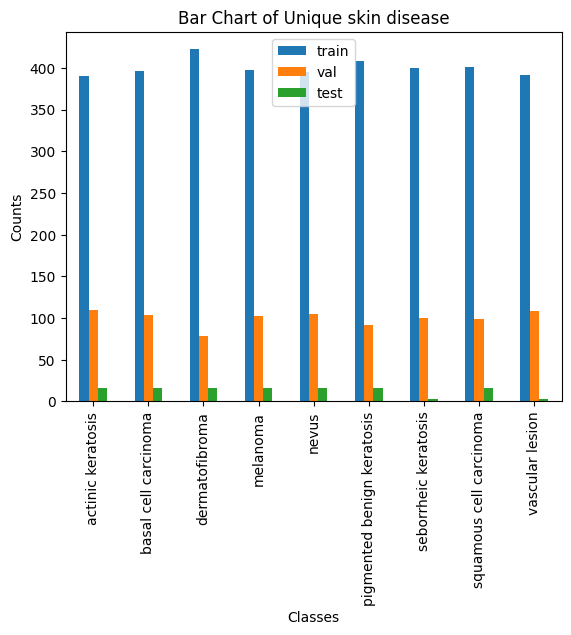

In [16]:

plt.figure(figsize=(10, 6))
sk_data.plot(kind='bar')

plt.xticks(rotation=90)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Bar Chart of Unique skin disease');

In [17]:
# Batch size for training, validation, and testing.
batch_size = 32 #32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

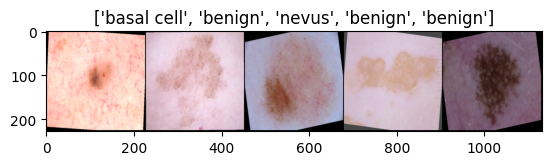

In [18]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['actininic', 'basal cell', 'dermatofibroma', 'melanoma', 'nevus',
               'benign', 'seborrheic', 'squamous', 'vascular']

imshow(out, title=[class_names[x] for x in classes])

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


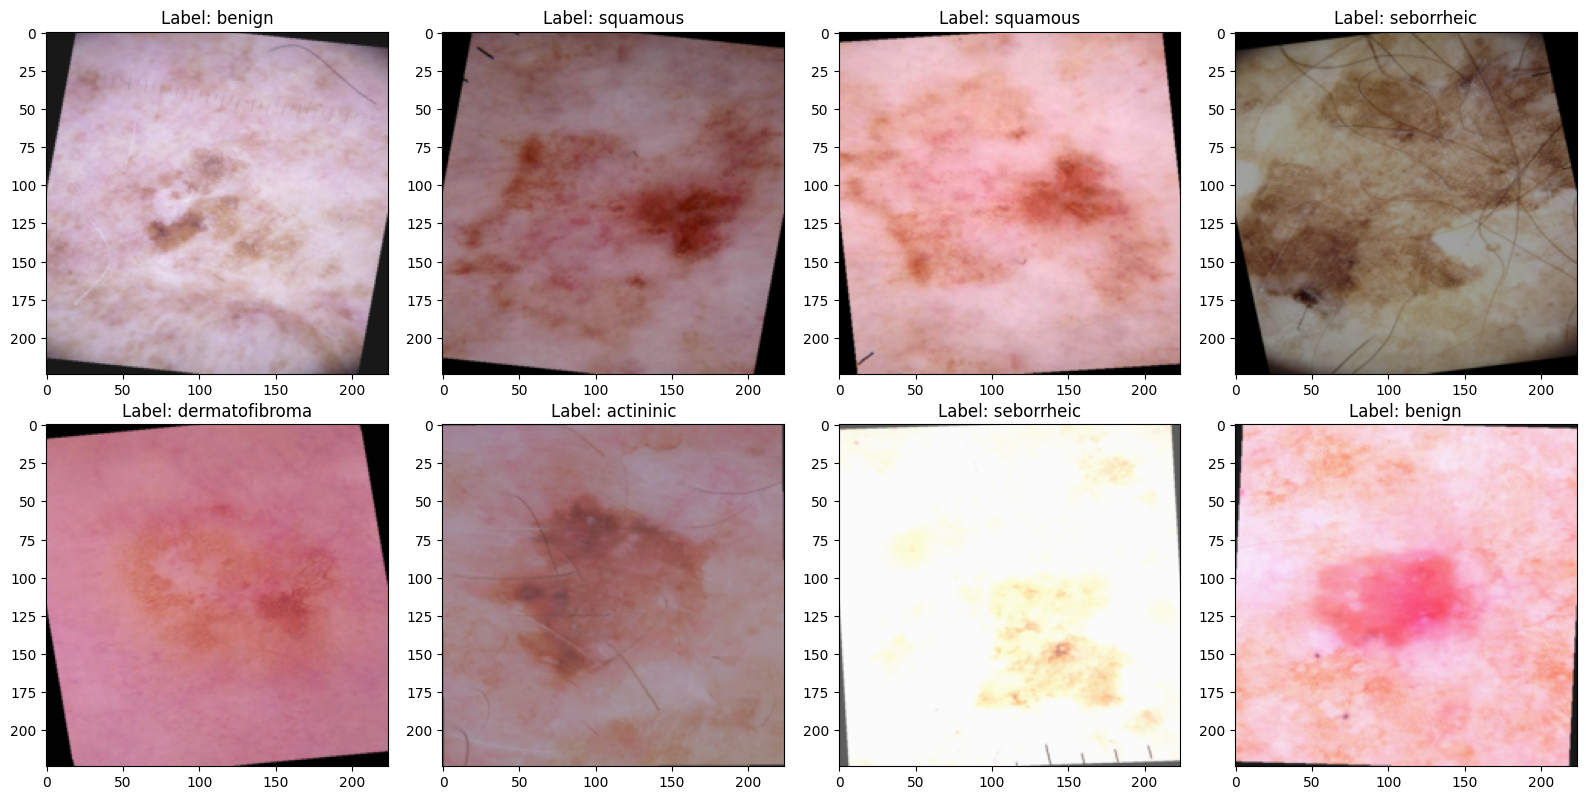

In [19]:


# Display images and labels.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label_names = ['actininic', 'basal cell', 'dermatofibroma', 'melanoma', 'nevus',
               'benign', 'seborrheic', 'squamous', 'vascular']

# Create a subplot grid with 2 rows and 4 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        # Transpose dimensions from (3, 224, 224) to (224, 224, 3)
        img = torch.transpose(train_features[i*4+j], 0, 2).numpy()
        label = train_labels[i*4+j]
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Label: {label_names[label]}")

plt.tight_layout()
plt.show()


# 3 Model

The basic model here is simply a stack of **convolutional layers** followed by some **fully-connected layers**.

Since there are three channels for a color image (RGB), the **input channels** of the network must be **three**.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the **feature map must be flattened into a single one-dimensional vector** (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.



In [20]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0

            # nn.Conv2d(256, 512, 3, 1, 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 9),

        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [21]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

GPU is available
GPU Device Name: Tesla T4


In [22]:

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

In [23]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Linear-13                  [-1, 256]      12,845,312
             ReLU-14                  [

# 4 Define Loss and Optimizer

In [24]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-02


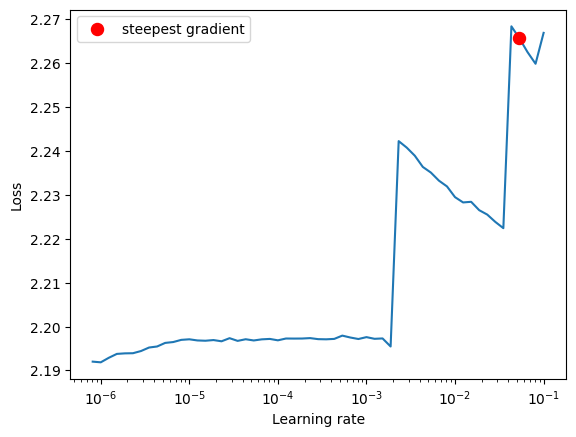

In [25]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

# Reference: https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.LearningRateFinder.html

In [26]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1.42E-04)

# 5 Train and Validation

In [27]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [29]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.5)
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)



    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')


    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=2.07188, acc=0.15819 | Valid: loss=1.87486, acc=0.21013


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=1.82538, acc=0.25608 | Valid: loss=1.75626, acc=0.29203


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=1.73622, acc=0.31388 | Valid: loss=1.69505, acc=0.32328


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=1.64831, acc=0.34541 | Valid: loss=1.63523, acc=0.37716


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=1.58352, acc=0.36726 | Valid: loss=1.54957, acc=0.40625


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=1.56700, acc=0.38468 | Valid: loss=1.50663, acc=0.42134


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 007/100] Train: loss=1.52518, acc=0.40791 | Valid: loss=1.49826, acc=0.42565


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 008/100] Train: loss=1.51884, acc=0.41261 | Valid: loss=1.46871, acc=0.43103


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 009/100] Train: loss=1.47547, acc=0.43252 | Valid: loss=1.46260, acc=0.43319


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 010/100] Train: loss=1.44595, acc=0.43031 | Valid: loss=1.41619, acc=0.46336


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 011/100] Train: loss=1.42464, acc=0.44552 | Valid: loss=1.41149, acc=0.45151


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 012/100] Train: loss=1.39224, acc=0.46018 | Valid: loss=1.33980, acc=0.49892


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 013/100] Train: loss=1.35807, acc=0.47096 | Valid: loss=1.40377, acc=0.45259


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 014/100] Train: loss=1.36560, acc=0.47069 | Valid: loss=1.37645, acc=0.47737


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 015/100] Train: loss=1.33948, acc=0.47981 | Valid: loss=1.34381, acc=0.47953


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 016/100] Train: loss=1.29194, acc=0.49945 | Valid: loss=1.26822, acc=0.52155


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 017/100] Train: loss=1.28354, acc=0.50636 | Valid: loss=1.28540, acc=0.50970


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 018/100] Train: loss=1.24095, acc=0.52046 | Valid: loss=1.27733, acc=0.49569


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 019/100] Train: loss=1.21860, acc=0.53650 | Valid: loss=1.25820, acc=0.51509


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 020/100] Train: loss=1.20096, acc=0.54895 | Valid: loss=1.26323, acc=0.53556


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 021/100] Train: loss=1.16638, acc=0.55503 | Valid: loss=1.21097, acc=0.53556


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 022/100] Train: loss=1.12886, acc=0.56803 | Valid: loss=1.34691, acc=0.49569


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 023/100] Train: loss=1.13197, acc=0.56554 | Valid: loss=1.22337, acc=0.54957


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 024/100] Train: loss=1.09784, acc=0.58628 | Valid: loss=1.14255, acc=0.58190


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 025/100] Train: loss=1.04999, acc=0.61034 | Valid: loss=1.17062, acc=0.57328


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 026/100] Train: loss=1.04870, acc=0.59707 | Valid: loss=1.14408, acc=0.57220


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 027/100] Train: loss=1.00699, acc=0.63302 | Valid: loss=1.15943, acc=0.54418


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 028/100] Train: loss=0.96491, acc=0.64242 | Valid: loss=1.27328, acc=0.54095


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 029/100] Train: loss=0.95563, acc=0.64851 | Valid: loss=1.08369, acc=0.61315


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 030/100] Train: loss=0.95769, acc=0.64795 | Valid: loss=1.02036, acc=0.61422


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 031/100] Train: loss=0.90758, acc=0.66040 | Valid: loss=1.11139, acc=0.60668


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 032/100] Train: loss=0.89178, acc=0.66814 | Valid: loss=1.03802, acc=0.63254


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 033/100] Train: loss=0.84421, acc=0.70050 | Valid: loss=1.02970, acc=0.63901


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 034/100] Train: loss=0.83308, acc=0.69248 | Valid: loss=1.08862, acc=0.63470


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 035/100] Train: loss=0.80008, acc=0.70686 | Valid: loss=0.99748, acc=0.64224


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 036/100] Train: loss=0.78772, acc=0.71792 | Valid: loss=1.00677, acc=0.66595


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 037/100] Train: loss=0.75955, acc=0.71543 | Valid: loss=1.04908, acc=0.64547


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 038/100] Train: loss=0.77013, acc=0.72013 | Valid: loss=0.99261, acc=0.64547


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 039/100] Train: loss=0.74068, acc=0.72788 | Valid: loss=0.93902, acc=0.65517


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 040/100] Train: loss=0.68595, acc=0.74613 | Valid: loss=1.00438, acc=0.65409


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 041/100] Train: loss=0.68984, acc=0.74364 | Valid: loss=0.97995, acc=0.63470


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 042/100] Train: loss=0.65347, acc=0.76300 | Valid: loss=0.97522, acc=0.65841


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 043/100] Train: loss=0.63769, acc=0.76687 | Valid: loss=0.90478, acc=0.70474


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 044/100] Train: loss=0.62077, acc=0.77323 | Valid: loss=0.89718, acc=0.69935


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 045/100] Train: loss=0.60299, acc=0.78346 | Valid: loss=0.90531, acc=0.70043


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 046/100] Train: loss=0.61750, acc=0.77517 | Valid: loss=0.95881, acc=0.67672


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 047/100] Train: loss=0.57114, acc=0.79010 | Valid: loss=0.90298, acc=0.70690


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 048/100] Train: loss=0.55274, acc=0.80144 | Valid: loss=0.87989, acc=0.71228


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 049/100] Train: loss=0.57321, acc=0.78816 | Valid: loss=0.88387, acc=0.71444


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 050/100] Train: loss=0.54334, acc=0.81001 | Valid: loss=0.91520, acc=0.71121


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 051/100] Train: loss=0.51447, acc=0.80918 | Valid: loss=0.90779, acc=0.71228


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 052/100] Train: loss=0.52919, acc=0.80697 | Valid: loss=0.97733, acc=0.68319


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 053/100] Train: loss=0.49555, acc=0.81471 | Valid: loss=0.94314, acc=0.70797


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 054/100] Train: loss=0.49250, acc=0.82439 | Valid: loss=0.92007, acc=0.70690


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 055/100] Train: loss=0.48564, acc=0.82826 | Valid: loss=0.86940, acc=0.72306


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 056/100] Train: loss=0.48763, acc=0.82494 | Valid: loss=0.81553, acc=0.73060


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 057/100] Train: loss=0.44883, acc=0.84098 | Valid: loss=0.85916, acc=0.74138


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 058/100] Train: loss=0.49646, acc=0.81167 | Valid: loss=0.78887, acc=0.76509


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 059/100] Train: loss=0.42685, acc=0.84707 | Valid: loss=0.85311, acc=0.73922


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 060/100] Train: loss=0.41278, acc=0.84790 | Valid: loss=0.91573, acc=0.74353


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 061/100] Train: loss=0.41859, acc=0.84458 | Valid: loss=0.86914, acc=0.73168


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 062/100] Train: loss=0.43374, acc=0.84209 | Valid: loss=0.90458, acc=0.71983


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 063/100] Train: loss=0.40032, acc=0.85205 | Valid: loss=1.03643, acc=0.70151


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 064/100] Train: loss=0.39953, acc=0.85011 | Valid: loss=0.90210, acc=0.74784


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 065/100] Train: loss=0.38264, acc=0.85675 | Valid: loss=0.81304, acc=0.77478


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 066/100] Train: loss=0.36216, acc=0.87058 | Valid: loss=0.90023, acc=0.75000


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 067/100] Train: loss=0.36539, acc=0.86836 | Valid: loss=0.84323, acc=0.76401


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 068/100] Train: loss=0.34282, acc=0.87915 | Valid: loss=0.81977, acc=0.74569


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

We are at epoch: 68


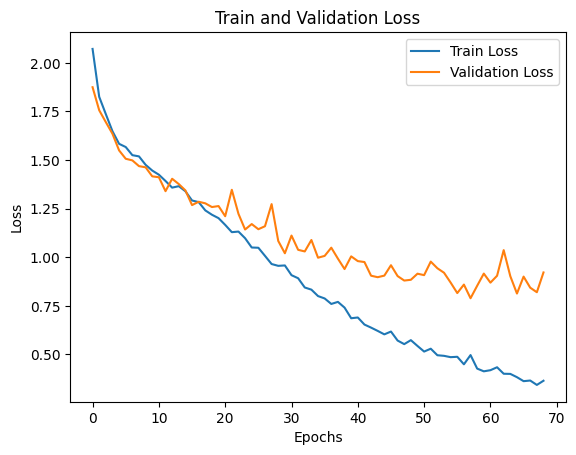

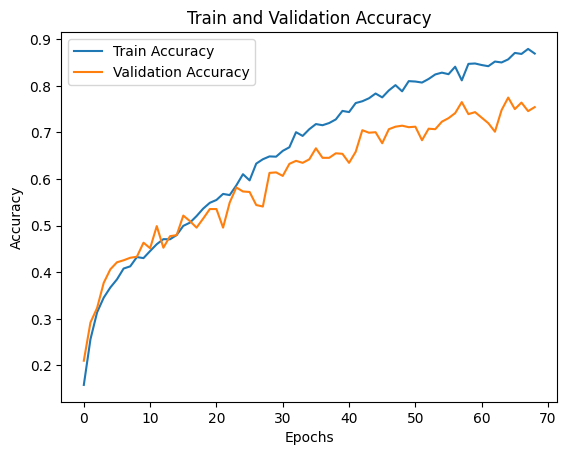

In [30]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# 6 Testing




In [31]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()
y_test=[]
y_pred = []

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    predictions = logits.argmax(dim=-1)

    y_test.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/4 [00:00<?, ?it/s]

Test accuracy 0.40340909361839294


In [32]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.25      0.33        16
           1       0.32      0.44      0.37        16
           2       0.86      0.38      0.52        16
           3       0.00      0.00      0.00        16
           4       0.42      0.94      0.58        16
           5       0.40      0.50      0.44        16
           6       0.00      0.00      0.00         3
           7       0.40      0.38      0.39        16
           8       0.40      0.67      0.50         3

    accuracy                           0.41       118
   macro avg       0.37      0.39      0.35       118
weighted avg       0.40      0.41      0.37       118



(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'actinic keratosis'),
  Text(1, 0, 'basal cell carcinoma'),
  Text(2, 0, 'dermatofibroma'),
  Text(3, 0, 'melanoma'),
  Text(4, 0, 'nevus'),
  Text(5, 0, 'pigmented benign keratosis'),
  Text(6, 0, 'seborrheic keratosis'),
  Text(7, 0, 'squamous cell carcinoma'),
  Text(8, 0, 'vascular lesion')])

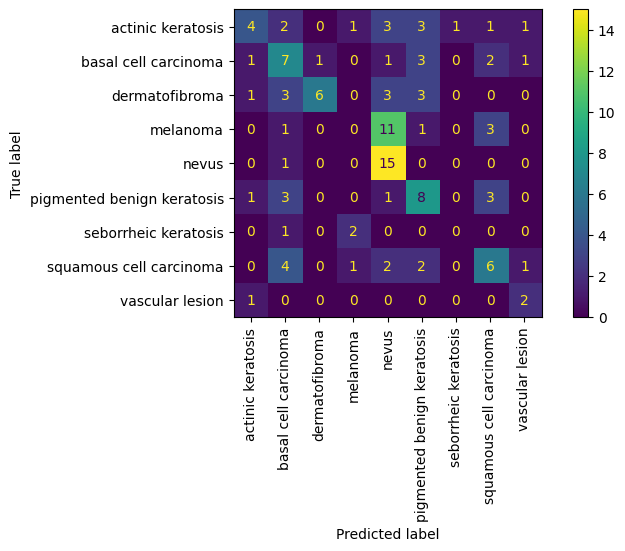

In [35]:

class_names = train_dataset.classes

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 4))
display.plot(ax=ax);


plt.xticks(rotation=90)

In [34]:
from sklearn.metrics import accuracy_score

# Compute the test accuracy using y_test and y_pred
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.4067796610169492


# ResNet18 - Fine tuning




In [ ]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc.out_features = 9
print(model)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1.42E-04)

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=1.0)
# The number of training epochs.
n_epochs = 35

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model_res.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 001/035] Train: loss=2.08435, acc=0.53215 | Valid: loss=1.00048, acc=0.68087


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 002/035] Train: loss=0.69311, acc=0.74732 | Valid: loss=0.65773, acc=0.76562


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 003/035] Train: loss=0.46369, acc=0.83258 | Valid: loss=0.83035, acc=0.70881


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 004/035] Train: loss=0.38199, acc=0.85941 | Valid: loss=0.58377, acc=0.78977


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 005/035] Train: loss=0.30881, acc=0.88915 | Valid: loss=0.58647, acc=0.81723


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 006/035] Train: loss=0.28672, acc=0.89818 | Valid: loss=0.62042, acc=0.80824


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 007/035] Train: loss=0.24690, acc=0.91409 | Valid: loss=0.37151, acc=0.86932


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 008/035] Train: loss=0.20893, acc=0.92217 | Valid: loss=0.38552, acc=0.88068


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 009/035] Train: loss=0.20002, acc=0.92708 | Valid: loss=0.38699, acc=0.88920


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 010/035] Train: loss=0.18451, acc=0.93209 | Valid: loss=0.36352, acc=0.89347


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 011/035] Train: loss=0.19433, acc=0.92454 | Valid: loss=0.46546, acc=0.83807


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 012/035] Train: loss=0.19698, acc=0.92917 | Valid: loss=0.39602, acc=0.85559


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 013/035] Train: loss=0.16122, acc=0.93906 | Valid: loss=0.49258, acc=0.85085


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 014/035] Train: loss=0.14588, acc=0.94873 | Valid: loss=0.33099, acc=0.89631


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 015/035] Train: loss=0.15099, acc=0.94459 | Valid: loss=0.41797, acc=0.87500


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 016/035] Train: loss=0.14374, acc=0.94023 | Valid: loss=0.34506, acc=0.89631


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 017/035] Train: loss=0.13123, acc=0.95290 | Valid: loss=0.48487, acc=0.86553


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 018/035] Train: loss=0.13618, acc=0.94609 | Valid: loss=0.35655, acc=0.89205


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 019/035] Train: loss=0.13508, acc=0.94665 | Valid: loss=0.33874, acc=0.90057


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 020/035] Train: loss=0.15449, acc=0.93785 | Valid: loss=0.54911, acc=0.84991


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 021/035] Train: loss=0.14985, acc=0.94040 | Valid: loss=0.46107, acc=0.87642


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 022/035] Train: loss=0.14999, acc=0.93984 | Valid: loss=0.33789, acc=0.89915


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 023/035] Train: loss=0.12016, acc=0.95133 | Valid: loss=0.41510, acc=0.88636


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 024/035] Train: loss=0.11953, acc=0.95006 | Valid: loss=0.46365, acc=0.88258


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 025/035] Train: loss=0.10867, acc=0.95625 | Valid: loss=0.38898, acc=0.88210


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 026/035] Train: loss=0.10755, acc=0.95967 | Valid: loss=0.37407, acc=0.88920


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 027/035] Train: loss=0.10081, acc=0.95918 | Valid: loss=0.51225, acc=0.84801


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 028/035] Train: loss=0.12016, acc=0.95267 | Valid: loss=0.38673, acc=0.89489


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 029/035] Train: loss=0.12235, acc=0.95159 | Valid: loss=0.49707, acc=0.85511


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 030/035] Train: loss=0.14435, acc=0.94306 | Valid: loss=0.50726, acc=0.83144


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 031/035] Train: loss=0.13349, acc=0.94691 | Valid: loss=0.43840, acc=0.87500


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 032/035] Train: loss=0.11965, acc=0.95162 | Valid: loss=0.42522, acc=0.87121


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 033/035] Train: loss=0.11340, acc=0.95547 | Valid: loss=0.42726, acc=0.86695


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 034/035] Train: loss=0.08872, acc=0.96198 | Valid: loss=0.37251, acc=0.88920


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 035/035] Train: loss=0.10365, acc=0.95964 | Valid: loss=0.45050, acc=0.87500


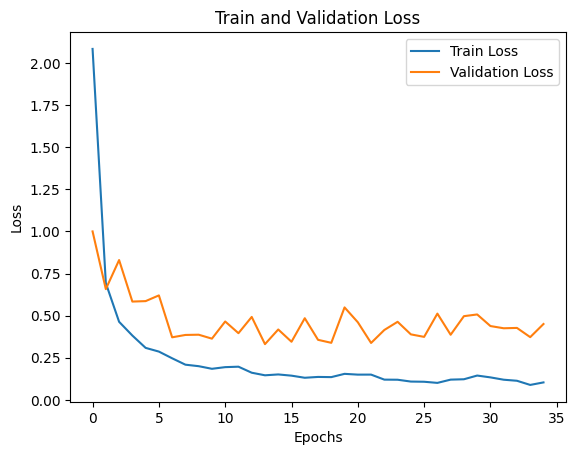

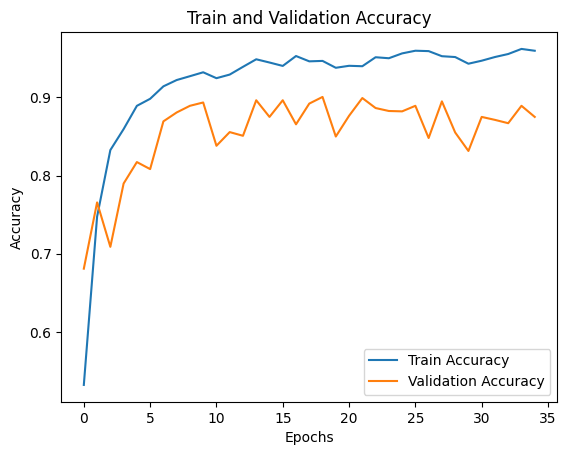

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model_res.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()
y_test=[]
y_pred = []

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    predictions = logits.argmax(dim=-1)

    y_test.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/4 [00:00<?, ?it/s]

Test accuracy 0.4886363744735718


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.12      0.22        16
           1       0.75      0.75      0.75        16
           2       0.86      0.38      0.52        16
           3       0.15      0.19      0.17        16
           4       0.38      0.94      0.54        16
           5       0.62      0.62      0.62        16
           6       0.00      0.00      0.00         3
           7       0.54      0.44      0.48        16
           8       1.00      1.00      1.00         3

    accuracy                           0.49       118
   macro avg       0.59      0.49      0.48       118
weighted avg       0.61      0.49      0.47       118



(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'actinic keratosis'),
  Text(1, 0, 'basal cell carcinoma'),
  Text(2, 0, 'dermatofibroma'),
  Text(3, 0, 'melanoma'),
  Text(4, 0, 'nevus'),
  Text(5, 0, 'pigmented benign keratosis'),
  Text(6, 0, 'seborrheic keratosis'),
  Text(7, 0, 'squamous cell carcinoma'),
  Text(8, 0, 'vascular lesion')])

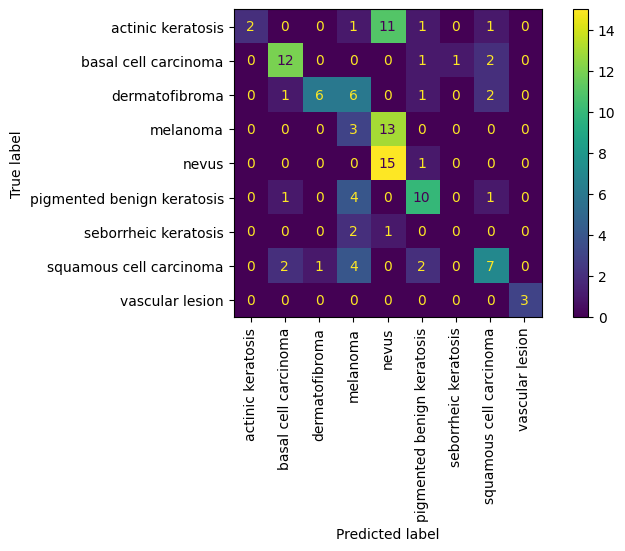

In [ ]:

class_names = train_dataset.classes

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 4))
display.plot(ax=ax);


plt.xticks(rotation=90)


# VGG16 - Fine Tuning




In [ ]:
# Load pre-trained VGG16 model with 9 output classes
model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=9)
model.train()
print(model)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-04


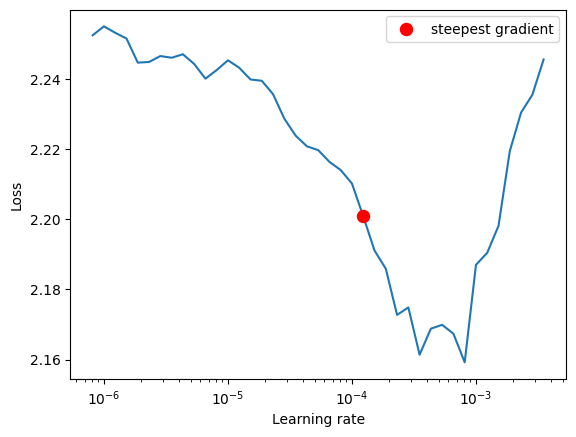

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1.42E-04)

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.5)
# The number of training epochs.
n_epochs = 30

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)



    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')


    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 001/030] Train: loss=1.62675, acc=0.37832 | Valid: loss=1.14251, acc=0.55496


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 002/030] Train: loss=1.15550, acc=0.55088 | Valid: loss=1.07633, acc=0.58297


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 003/030] Train: loss=0.96635, acc=0.61864 | Valid: loss=0.94188, acc=0.62931


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 004/030] Train: loss=0.79239, acc=0.69746 | Valid: loss=0.81529, acc=0.68211


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 005/030] Train: loss=0.69230, acc=0.72705 | Valid: loss=0.60925, acc=0.77371


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 006/030] Train: loss=0.54459, acc=0.78595 | Valid: loss=0.73531, acc=0.73491


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 007/030] Train: loss=0.51467, acc=0.80116 | Valid: loss=0.55760, acc=0.80819


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 008/030] Train: loss=0.43876, acc=0.83131 | Valid: loss=0.55093, acc=0.81789


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 009/030] Train: loss=0.40429, acc=0.84596 | Valid: loss=0.50555, acc=0.84159


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 010/030] Train: loss=0.37279, acc=0.86200 | Valid: loss=0.51019, acc=0.79634


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 011/030] Train: loss=0.31332, acc=0.87832 | Valid: loss=0.65233, acc=0.81142


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 012/030] Train: loss=0.32566, acc=0.87611 | Valid: loss=0.45364, acc=0.87069


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 013/030] Train: loss=0.31478, acc=0.88219 | Valid: loss=0.41914, acc=0.85345


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 014/030] Train: loss=0.25909, acc=0.90127 | Valid: loss=0.47230, acc=0.82543


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 015/030] Train: loss=0.21102, acc=0.91593 | Valid: loss=0.50001, acc=0.85776


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 016/030] Train: loss=0.24046, acc=0.90985 | Valid: loss=0.46689, acc=0.85022


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 017/030] Train: loss=0.31177, acc=0.88496 | Valid: loss=0.34658, acc=0.88147


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 018/030] Train: loss=0.20098, acc=0.92284 | Valid: loss=0.52292, acc=0.84914


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 019/030] Train: loss=0.22254, acc=0.91427 | Valid: loss=0.42943, acc=0.86530


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 020/030] Train: loss=0.19750, acc=0.92312 | Valid: loss=0.57866, acc=0.81358


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 021/030] Train: loss=0.23381, acc=0.91510 | Valid: loss=0.48859, acc=0.83621


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 022/030] Train: loss=0.19809, acc=0.91814 | Valid: loss=0.43434, acc=0.85884


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 023/030] Train: loss=0.15556, acc=0.93971 | Valid: loss=0.39736, acc=0.88147


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 024/030] Train: loss=0.15865, acc=0.93473 | Valid: loss=0.39285, acc=0.89547


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 025/030] Train: loss=0.19298, acc=0.93059 | Valid: loss=0.37931, acc=0.87931


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 026/030] Train: loss=0.21387, acc=0.91869 | Valid: loss=0.44263, acc=0.85560


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 027/030] Train: loss=0.20381, acc=0.92257 | Valid: loss=0.44810, acc=0.85776


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 028/030] Train: loss=0.16663, acc=0.93612 | Valid: loss=0.37609, acc=0.88685


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 029/030] Train: loss=0.13245, acc=0.94912 | Valid: loss=0.36417, acc=0.87823


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

[Epoch: 030/030] Train: loss=0.17044, acc=0.93529 | Valid: loss=0.57244, acc=0.80065


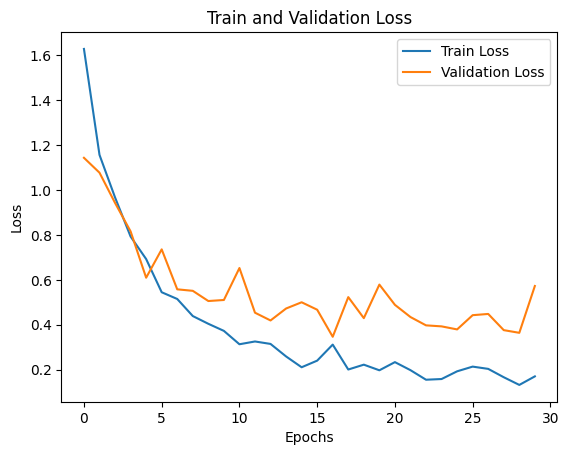

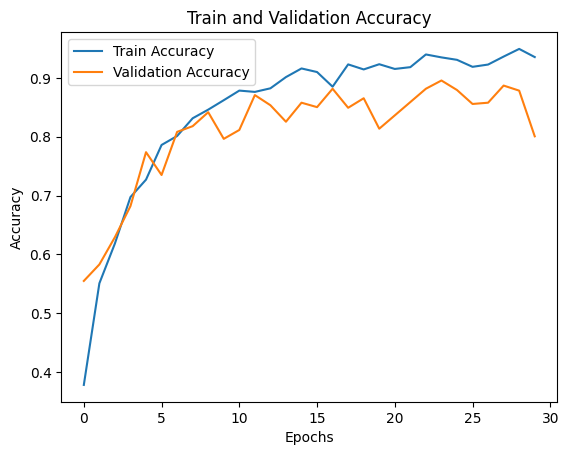

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()
y_test=[]
y_pred = []

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    predictions = logits.argmax(dim=-1)

    y_test.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/4 [00:00<?, ?it/s]

Test accuracy 0.5355113744735718


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.44      0.54        16
           1       0.83      0.62      0.71        16
           2       0.77      0.62      0.69        16
           3       0.00      0.00      0.00        16
           4       0.41      1.00      0.58        16
           5       0.58      0.69      0.63        16
           6       0.00      0.00      0.00         3
           7       0.64      0.44      0.52        16
           8       1.00      1.00      1.00         3

    accuracy                           0.54       118
   macro avg       0.55      0.53      0.52       118
weighted avg       0.56      0.54      0.52       118



(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'actinic keratosis'),
  Text(1, 0, 'basal cell carcinoma'),
  Text(2, 0, 'dermatofibroma'),
  Text(3, 0, 'melanoma'),
  Text(4, 0, 'nevus'),
  Text(5, 0, 'pigmented benign keratosis'),
  Text(6, 0, 'seborrheic keratosis'),
  Text(7, 0, 'squamous cell carcinoma'),
  Text(8, 0, 'vascular lesion')])

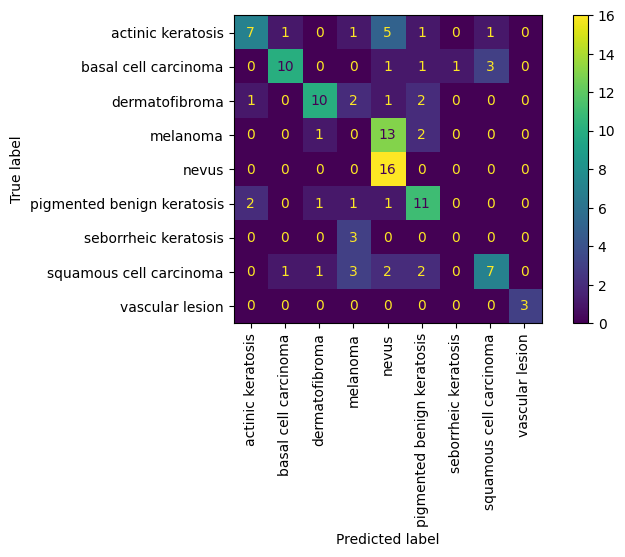

In [ ]:

class_names = train_dataset.classes

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 4))
display.plot(ax=ax);


plt.xticks(rotation=90)

# Ackowledgement

This lab is modified by Ayomide Popoola for Deep Learning at Manchester Metropolitan University.

The original jupyter notebook was developed for the Machine Learning course offered by Prof. Hung-yi Lee from Department of Electrical Engineering, National Taiwan University.